In [ ]:
from google.colab import drive #ignorar si no en Colab
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/GitHub_prep/')

In [ ]:
!pip install --upgrade jax jaxlib netket optax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.1/721.1 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully uninstalled jax-0.5.

In [ ]:
import os
import sys
import argparse
from typing import Sequence, Tuple, List


import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
import pandas as pd


import jax
import jax.numpy as jnp
import jaxlib
import flax
import flax.linen as nn
import optax


import netket as nk
import netket.experimental as nkx
from netket.sampler import MetropolisRule
from netket.utils.struct import dataclass
from netket.operator.spin import sigmax, sigmaz

import scipy.linalg

In [ ]:
print(jax.__version__)
print(jaxlib.__version__)
print(nk.__version__)
print(optax.__version__)
print(np.__version__)
print(flax.__version__)

0.5.3
0.5.3
3.18
0.2.5
2.0.2
0.10.6


In [ ]:
from utils import circulant, BestIterKeeper,InvertMagnetization

In [ ]:
from hamiltonian import get_Hamiltonian,get_eigvals

In [ ]:
from ubon_ansatz import NodeMLP, node_level_MLP, graph_level_MLP, sym_UBoN

In [ ]:
from funciones_auxiliares import *

In [ ]:
def make_extract_metrics(metrics_history):
  '''
  Función que extrae metricas durante la optimización.
  '''
  def extract_metrics(step, log_data, driver):
      stats = driver.state.expect(H)
      energy = float(jnp.real(stats.mean))
      energy_error = float(jnp.real(stats.error_of_mean))

      loss = float(jnp.real(getattr(log_data[driver._loss_name], "mean")))
      variance = float(jnp.real(getattr(log_data[driver._loss_name], "variance")))

      metrics_history['step'].append(step)
      metrics_history['energy'].append(energy)
      metrics_history['energy_error'].append(energy_error)
      metrics_history['loss'].append(loss)
      metrics_history['variance'].append(variance)

      print(f"Step {step}: Energy = {energy:.6f} ± {energy_error:.2e}, Loss = {loss:.4f}, Variance = {variance:.4f}")
      return True

  return extract_metrics


In [ ]:
diagonalize = True #Diagonalizamos con Lanczos
trivial = True #Soluciones triviales o no triviales
N = 20
alpha = 3.0
J = -5.0
b = 2
h=-1
num_message_pass = [1]


In [ ]:
# Creación del espacio de Hilbert y otros observables
hi = nk.hilbert.Spin(s=1 / 2, N=N)

renyi = nkx.observable.Renyi2EntanglementEntropy(
    hi, np.arange(0, N / 2 + 1, dtype=int)
)
mags = sum([(-1) ** i * sigmaz(hi, i) / N for i in range(N)])
magnet = sum([sigmaz(hi, i) / N for i in range(N)])


In [ ]:
# MC regla de muestreo
rule1 = nk.sampler.rules.LocalRule()
pflip = 1
sampler = nk.sampler.MetropolisSampler(
    hi, nk.sampler.rules.MultipleRules([rule1], [pflip])
)


In [ ]:
# Protocolo de entrenamiento
max_iters = 700 #700
ramp_iter = 50
lrmax = 1.0

lr_schedule = optax.warmup_exponential_decay_schedule(
    init_value=1e-2,
    peak_value=0.05,
    warmup_steps=30,
    transition_steps=100,
    decay_rate=0.97
)

optimizer = nk.optimizer.Sgd(learning_rate = lr_schedule)

ds_schedule = optax.linear_schedule(1e-3, 1e-5, max_iters)

SR = nk.optimizer.SR(diag_shift=ds_schedule)


In [ ]:
order = 20

# Hamiltoniano
H ,N_norm  = get_Hamiltonian(N=N, J=J, alpha=alpha, return_norm=True) #establecemos el hamiltoniano de rango alcance y el factor de normalización

with jax.default_device(jax.devices("cpu")[0]):
    Egs, eigenvec = get_eigvals(Hamiltonian=H, order=order, eigenvecs=True)



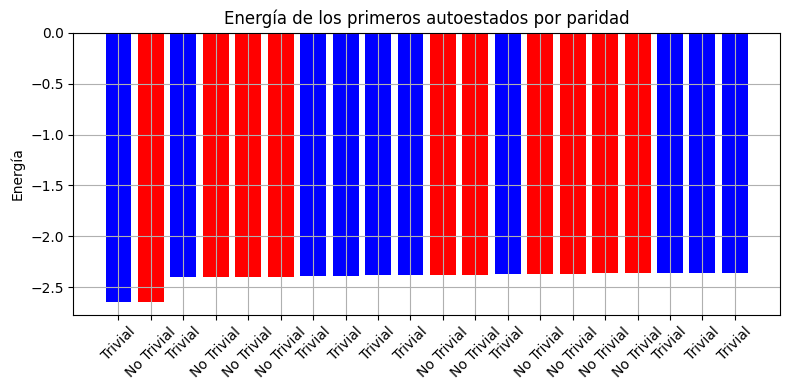

In [ ]:
soluciones = []
energias = []

#vemos si pertenecen los autoestados a la irrep trivial o no trivial
for i in range(eigenvec.shape[1]):
    v = eigenvec[:, i]
    is_odd = jnp.allclose(v + v[::-1], 0.0, atol=1e-5) # vemos si la inversión de
    soluciones.append('No Trivial' if is_odd else 'Trivial')
    energias.append(Egs[i])

# visualizamos las irreps
plt.figure(figsize=(8, 4))
colors = ['red' if p == 'No Trivial' else 'blue' for p in soluciones]
plt.bar(range(len(energias)), energias, color=colors)
plt.xticks(range(len(energias)), soluciones, rotation=45)
plt.ylabel("Energía")
plt.title("Energía de los primeros autoestados por paridad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
exchange_matrix = get_exchange_matrix(N_norm, b, N, alpha=alpha, J=J)

In [ ]:
exchange_matrix_normalized = get_normalized_matrix(exchange_matrix)

In [ ]:
eigenvals, eigenvecs = scipy.linalg.eigh(exchange_matrix_normalized)
eigenvals_matrix = np.diag(np.sqrt(np.abs(eigenvals)))
augmentation_matrix = eigenvecs @ eigenvals_matrix  # La matriz de codificación EASE (N, N)

In [ ]:
#definimos el modelo
modelosUBoN = []
for i in num_message_pass:

  model = sym_UBoN(
        trivial=trivial,
        N=N,
        augmentation=augmentation_matrix
  )

  model_name = model.__class__.__name__
  modelosUBoN.append(model)


In [ ]:
import time

seed = int(time.time()) #creamos seed pseudoaleatoria para inicializar estado

In [ ]:
# Inicialización de estado de Montecarlo
vstate_list = []
gs_list = []
keeper_list = []
log_list = []


for i, model in enumerate(modelosUBoN):

  vstate = nk.vqs.MCState(
      sampler,
      model,
      n_samples=240,
      n_discard_per_chain=0,
      chunk_size=60,
      seed = seed
  )

  gs = nk.driver.VMC(
      H,
      optimizer,
      variational_state=vstate,
      preconditioner=SR,# stochastic reconfiguration
  )

  keeper = BestIterKeeper(H, N, 1e-8)
  log = nk.logging.RuntimeLog()

  #guardamos todas las inicializaciones y drivers, en el caso de UBoN 1 sólo
  vstate_list.append(vstate)
  gs_list.append(gs)
  keeper_list.append(keeper)
  log_list.append(log)


(1, 20)
(1, 20)
(16, 20)
(16, 20)


/usr/local/lib/python3.11/dist-packages/netket/vqs/mc/mc_state/state.py:306: UserWarning: For performance reasons, we suggest to use a power-of-two chunk size.
  self.chunk_size = chunk_size


In [ ]:
for i in vstate_list:
  n_params = sum(x.size for x in jax.tree_util.tree_leaves(i.parameters))
  print("Número total de parámetros:", n_params)

Número total de parámetros: 13378


In [ ]:
#guardamos la primera energía, como se inicializa
vstate_init =  []
for vstate in vstate_list:
  vstate_init.append(vstate.expect(H))

(16, 20)
(16, 20)
(16, 20)
(16, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)


In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/first_energies.txt" # Ajustar el directorio
with  open(file_path, 'w') as f:
    for vstate in vstate_init:
        print(vstate, file=f)
    print("ground_energy=" ,Egs[0] , file=f)

In [ ]:
metrics_history = [{'step': [], 'energy': [], 'energy_error': [], 'loss': [], 'variance': []} for _ in range(len(num_message_pass))] #creamos el diccionario donde se guarda la métrica

In [ ]:
# Llevamos a cabo la optimización qVMC
for i, gs in enumerate(gs_list):
    # Crea el callback específico para el i-ésimo modelo
    callback_fn = [keeper_list[i].update, make_extract_metrics(metrics_history[i])]

    gs.run(n_iter=max_iters, out = log_list[i], callback=callback_fn, show_progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
(60, 20)
(60, 20)
(60, 20)
(60, 20)
(60, 20)
(60, 20)
(60, 20)
(60, 20)
(240, 20)
(240, 20)
(1, 20)
(1, 20)
(1, 20)
(1, 20)
Step 0: Energy = -1.738827 ± 2.15e-02, Loss = -1.7388, Variance = 0.1112
Step 1: Energy = -1.726027 ± 2.09e-02, Loss = -1.7260, Variance = 0.1048
Step 2: Energy = -1.756649 ± 2.27e-02, Loss = -1.7566, Variance = 0.1239
Step 3: Energy = -1.746740 ± 2.05e-02, Loss = -1.7467, Variance = 0.1010
Step 4: Energy = -1.761095 ± 2.01e-02, Loss = -1.7611, Variance = 0.0974
Step 5: Energy = -1.739882 ± 2.09e-02, Loss = -1.7399, Variance = 0.1050
Step 6: Energy = -1.739348 ± 2.08e-02, Loss = -1.7393, Variance = 0.1040
Step 7: Energy = -1.717746 ± 2.12e-02, Loss = -1.7177, Variance = 0.1075
Step 8: Energy = -1.770402 ± 2.28e-02, Loss = -1.7704, Variance = 0.1246
Step 9: Energy = -1.754079 ± 2.04e-02, Loss = -1.7541, Variance = 0.1002
Step 10: Energy = -1.698105 ± 1.98e-02, Loss = -1.6981, Variance = 0.0940
Step 11:

In [ ]:
metrics_history = np.array(metrics_history)

In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/metrics_data.txt" # Ajustar el path
with open(file_path, 'w') as f:
    np.savetxt(f, metrics_history.T, fmt='%s', delimiter='\t')
    print(f"Metrica guardada en: {file_path}")

In [ ]:
energia_min_array = []
for i in range(len(num_message_pass)):
  energia_min_array.append(keeper_list[i].best_energy)

In [ ]:
'''
No usamos muchas métricas aquí obtenidas, pero dejamos su cálculo para futuras mejoras.
'''
file_path = "/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/evaluation_results.txt"  # Ajustar el path
with open(file_path, 'w') as f:
    for keeper in keeper_list:
        if diagonalize:
            fidelity = np.abs(keeper.best_state.to_array().conj() @ eigenvec[:, 0])
            rel_err = np.abs((keeper.best_energy - Egs[0]) / Egs[0])
            print(f"Fidelity: {fidelity:.5f}", file=f)
            print(f"Relative error in energy: {rel_err:.2E}", file=f)
        vsc = keeper.vscore
        print(f"V-score: {vsc:.2E}", file=f)
        S = np.real(keeper.best_state.expect(renyi).mean)
        print(f"Value for the Renyi-2 entropy: {S:.5f}", file=f)
        m = np.real(keeper.best_state.expect(magnet).mean)
        print(f"Value for the magnetization: {m:.5f}", file=f)
        ms = np.real(keeper.best_state.expect(mags).mean)
        print(f"Value for the staggered magnetization: {ms:.5f}", file=f)
        fluct = np.real(keeper.best_state.expect(magnet @ magnet).mean)
        print(f"Value for the squared magnetization: {fluct:.5f}", file=f)
        fluct_s = np.real(keeper.best_state.expect(mags @ mags).mean)
        print(f"Value for the squared staggered magnetization: {fluct_s:.5f}", file=f)
    print(f"Resultados guardados para: {file_path}")

In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/TFG/transformer_LR_WF/fidelities.txt" # Ajustar el path
rows = []

for keeper in keeper_list:
    if diagonalize:
        ψ_impar = keeper.best_state.to_array()
        for i in range(order):
            fid = np.abs(ψ_impar.conj() @ eigenvec[:, i])
            rel_err = np.abs((keeper.best_energy - Egs[i]) / Egs[i])
            rows.append({
                "Estado": i,
                "Solucion": soluciones[i],
                "Energía": Egs[i],
                "Fidelidad": fid,
                "Error relativo": f"{rel_err}"
            })

# crear DataFrame y guardar como tabla alineada
df = pd.DataFrame(rows)
with open(file_path, 'w') as f:
    f.write("Fidelidades con estados exactos:\n")
    f.write(df.to_string(index=False))
